### How to extend the ROMC class with custom methods

In this notebook, we will illustrate how one can use the ROMC inference method with custom methods.

Specifically, instead of constructing the bounding box using the ROMC's builtin method, we will use a custom one which blindly returns a box with side 2.

In the same manner, the user may also replace the utilities:

* sample_gradients
* sample_bo
* fit_models



In [1]:
import timeit
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.stats as ss
import elfi

np.random.seed(21)

## Ground-truth posterior approximation

In [2]:
class Prior:
    def rvs(self, size=None, random_state=None):
        # size from (BS,) -> (BS,1)
        if size is not None:
            size = np.concatenate((size, [1]))
        return ss.uniform(loc=-2.5, scale=5).rvs(size=size, random_state=random_state)

    def pdf(self, theta):
        return ss.uniform(loc=-2.5, scale=5).pdf(theta)

    def logpdf(self, theta):
        return ss.uniform(loc=-2.5, scale=5).logpdf(theta)

In [3]:
class Likelihood:
    r"""Implements the distribution
    P(x|theta) = N(x; theta^4, 1)         if theta in [-0.5, 0.5]
                 N(x; theta + 0.5 + 0.5^4 if theta > 0.5
                 N(x; theta - 0.5 + 0.5^4 if theta < 0.5
    """

    def rvs(self, theta, seed=None):
        """Vectorized sampling from likelihood.

        """
        assert isinstance(theta, np.ndarray)
        theta = theta.astype(np.float)
        samples = np.empty_like(theta)

        c = 0.5 - 0.5 ** 4

        tmp_theta = theta[theta <= -0.5]
        samples[theta <= -0.5] = ss.norm(loc=-tmp_theta - c, scale=1).rvs(random_state=seed)
        theta[theta <= -0.5] = np.inf

        tmp_theta = theta[theta <= 0.5]
        samples[theta <= 0.5] = ss.norm(loc=tmp_theta**4, scale=1).rvs(random_state=seed)
        theta[theta <= 0.5] = np.inf

        tmp_theta = theta[theta < np.inf]
        samples[theta < np.inf] = ss.norm(loc=tmp_theta - c, scale=1).rvs(random_state=seed)
        theta[theta < np.inf] = np.inf

        assert np.allclose(theta, np.inf)
        return samples

    def pdf(self, x, theta):
        """Vectorised pdf evaluation.
        """
        assert isinstance(x, np.ndarray)
        assert isinstance(theta, np.ndarray)
        assert theta.ndim == 1
        assert x.ndim == 1

        BS = theta.shape[0]
        N = x.shape[0]
        theta = theta.astype(np.float)

        pdf_eval = np.zeros((BS))
        c = 0.5 - 0.5 ** 4

        def help_func(lim, mode):
            tmp_theta = theta[theta <= lim]
            tmp_theta = np.expand_dims(tmp_theta, -1)
            scale = np.ones_like(tmp_theta)
            if mode == 1:
                pdf_eval[theta <= lim] = np.prod(ss.norm(loc=-tmp_theta - c, scale=scale).pdf(x), 1)
            elif mode == 2:
                pdf_eval[theta <= lim] = np.prod(ss.norm(loc=tmp_theta**4, scale=scale).pdf(x), 1)
            elif mode == 3:
                pdf_eval[theta <= lim] = np.prod(ss.norm(loc=tmp_theta - c, scale=scale).pdf(x), 1)
            theta[theta <= lim] = np.inf

        big_M = 10**7
        help_func(lim=-0.5, mode=1)
        help_func(lim=0.5, mode=2)
        help_func(lim=big_M, mode=3)
        assert np.allclose(theta, np.inf)
        return pdf_eval

In [4]:
def summary(x):
    assert isinstance(x, np.ndarray)
    if x.ndim == 1:
        return x
    elif x.ndim == 2:
        return np.prod(x, 1)


def create_factor(x):
    """Creates the function g(theta) = L(theta)*prior(theta).

    """
    lik = Likelihood()
    pr = Prior()
    def tmp_func(theta):
        return float(lik.pdf(x, np.array([theta])) * pr.pdf(theta))
    return tmp_func


def approximate_Z(func, a, b):
    """Approximates the partition function with exhaustive integration.
    """
    return integrate.quad(func, a, b)[0]


def create_gt_posterior(likelihood, prior, data, Z):
    """Returns a function that computes the gt posterior
    """
    def tmp_func(theta):
        return likelihood.pdf(data, np.array([theta])) * prior.pdf(np.array([theta])) / Z
    return tmp_func

def compute_gt_mean(pdf):
    def integrad(x):
        return x*pdf(x)
    return integrate.quad(integrad, -3, 3)

def compute_gt_variance(pdf, mean):
    def integrad(x):
        return (x**2 - mean)*pdf(x)
    return np.sqrt(integrate.quad(integrad, -3, 3))

In [5]:
data = np.array([0.])
dim = data.shape[0]
a = -2.5  # integration left limit
b = 2.5   # integration right limit

likelihood = Likelihood()
prior = Prior()

factor = create_factor(x=data)
Z = approximate_Z(factor, a, b)
gt_posterior_pdf = create_gt_posterior(likelihood, prior, data, Z)
gt_posterior_mean = compute_gt_mean(gt_posterior_pdf)[0]
gt_posterior_var = compute_gt_variance(gt_posterior_pdf, gt_posterior_mean)[0]

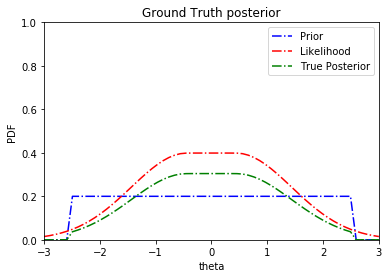

In [6]:
plt.figure()
plt.title("Ground Truth posterior")
plt.xlim(-3, 3)
plt.xlabel("theta")
plt.ylabel("PDF")
plt.ylim(0, 1)

# plot prior
theta = np.linspace(-3, 3, 60)
y = prior.pdf(theta)
plt.plot(theta, y, 'b-.', label='Prior')

# plot likelihood
y = likelihood.pdf(x=data, theta=theta)
plt.plot(theta, y, 'r-.', label='Likelihood')

# plot posterior
y = np.squeeze(np.array([gt_posterior_pdf(th) for th in theta]))
plt.plot(theta, y, 'g-.', label="True Posterior")

plt.legend()
plt.show(block=False)

## Define the model at elfi

In [7]:
def simulator(theta, dim, batch_size=10000, random_state=None):
    likelihood = Likelihood()
    theta = np.repeat(theta, dim, -1)
    return likelihood.rvs(theta, seed=random_state)


elfi.new_model("1D_example")
elfi_prior = elfi.Prior(Prior(), name="theta")
elfi_simulator = elfi.Simulator(simulator, elfi_prior, dim, observed=np.expand_dims(data, 0), name="simulator")
dist = elfi.Distance('euclidean', elfi_simulator, name="dist")

In [8]:
bounds = [(-2.5, 2.5)]
dim = data.shape[-1]

class customOptim(elfi.methods.parameter_inference.OptimisationProblem):
    def __init__(self, **kwargs):
        super(customOptim, self).__init__(**kwargs)
        
    def build_region(self, **kwargs):
        
        # compute bounding box
        rotation = np.eye(1)
        theta_0 = self.result.x_min
        
        bounding_box = np.array([[theta_0[0]-1, theta_0[0]+1]])
        eps = kwargs["eps_region"]
        
        self.regions = [elfi.methods.parameter_inference.NDimBoundingBox(rotation, theta_0, bounding_box, eps)]
        
        # update state
        self.eps_region = kwargs["eps_region"]
        self.state["region"] = True
        return True

# Defines the ROMC inference method
romc = elfi.ROMC(dist, bounds, custom_optim_class=customOptim)

## Training part, using gradient-based optimizer

In [9]:
# Define and solve n1 optimisation problems
n1 = 500
seed = 21
optimizer_args = {}
use_bo=False
romc.solve_problems(n1=n1, seed=seed, use_bo=use_bo, optimizer_args=optimizer_args)

### Solving problems using a gradient-based method ###
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Time: 21.329 sec
Time: 21.329 sec


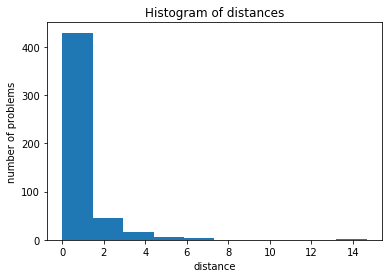

In [10]:
# plots the disribution of optimal distances
romc.distance_hist()

In [11]:
eps_filter = .75
fit_models = False
fit_models_args = {"nof_points":30}
romc.estimate_regions(eps_filter=eps_filter, fit_models=fit_models, fit_models_args=fit_models_args)

Total solutions: 500, Accepted solutions after filtering: 386
### Estimating regions ###

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Time: 0.095 sec 



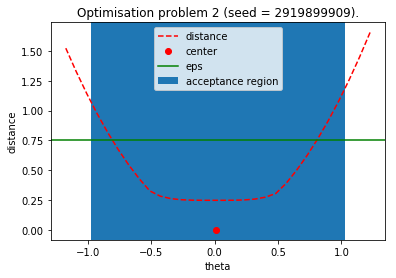

In [12]:
romc.visualize_region(2)

## Inference

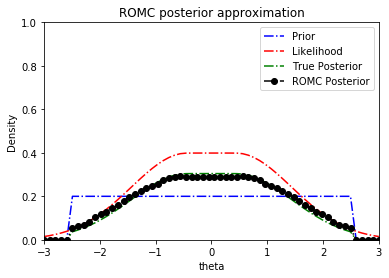

In [13]:
# make plot
plt.figure()
plt.title("ROMC posterior approximation")
plt.xlim(-3, 3)
plt.xlabel("theta")
plt.ylabel("Density")
plt.ylim(0, 1)

# plot prior
theta = np.linspace(-3, 3, 60)
y = prior.pdf(theta)
plt.plot(theta, y, 'b-.', label='Prior')

# plot likelihood
y = likelihood.pdf(x=data, theta=theta)
plt.plot(theta, y, 'r-.', label='Likelihood')

# plot posterior
y = np.squeeze(np.array([gt_posterior_pdf(th) for th in theta]))
plt.plot(theta, y, 'g-.', label="True Posterior")

# plot ROMC posterior
y = [romc.eval_posterior(np.array([[th]])) for th in theta]
tmp = np.squeeze(np.array(y))
plt.plot(theta, tmp, 'k-.o', label="ROMC Posterior")

plt.legend()
plt.show(block=False)

In [14]:
n2 = 200
tmp = romc.sample(n2=n2)

### Getting Samples from the posterior ###



KeyboardInterrupt: 

In [ ]:
# As before but now it plots the samples as well
romc.visualize_region(2)

In [ ]:
# compute expectation
print("Expected mean    : %.3f, ground-truth: %.3f" % (romc.compute_expectation(h = lambda x: np.squeeze(x)), gt_posterior_mean))
print("Expected variance: %.3f, ground-truth: %.3f" % (romc.compute_expectation(h =lambda x: np.squeeze(x)**2), gt_posterior_var))

## Evaluation of the inference

In [ ]:
# compute divergence
def wrapper(x):
    """gt_posterior_pdf with batching.
    """
    res = []
    for i in range(x.shape[0]):
        tmp = x[i]
        res.append(gt_posterior_pdf(float(tmp)))
    return np.array(res)

print("Divergence from ground-truth, using Jensen-Shannon distance: %.3f" % romc.compute_divergence(wrapper, distance="Jensen-Shannon"))

In [ ]:
# compute ESS
print("Nof Samples: %d, ESS: %.3f" % (len(romc.result.weights), romc.compute_ess()))

In [ ]:
# plot histogram of samples
plt.figure()
plt.title("Histogram of samples drawn from the posterior")
plt.hist(romc.result.samples_array, weights=romc.result.weights, bins=100, density=True, range=(-3,3))

theta = np.linspace(-3, 3, 60)
y = np.squeeze(np.array([gt_posterior_pdf(th) for th in theta]))
plt.plot(theta, y, 'r-o', label="True Posterior")

plt.ylim([0, .6])
plt.xlabel('theta')
plt.ylabel('density')
plt.show()